In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [56]:
df = pd.read_csv('weekly_dmd.csv')
df['date'] = pd.to_datetime(df.date).apply(lambda x: x.date())
df = df.set_index(df.date)
df.index.rename('date_idx', inplace=True)
df.head(2)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag-1,total_demand_new_lag-2,smoothed_total_demand,year
date_idx,,,,,,,,,
2017-06-26,1,2017-06-26,1656.912757,NaN,NaN,1678.654277,2193.532475,NaN,2017
2017-06-26,655,2017-06-26,0.000000,NaN,NaN,0.000000,0.000000,NaN,2017


In [57]:
df1 = df.loc[df.zone_id == 1].sort_values('date')
df1.tail(3)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag-1,total_demand_new_lag-2,smoothed_total_demand,year
date_idx,,,,,,,,,
2021-06-07,1,2021-06-07,3647.575226,3646.368284,3621.476264,3636.043192,3554.985482,3614.718305,2021
2021-06-14,1,2021-06-14,3636.043192,3647.575226,3646.368284,3554.985482,NaN,NaN,2021
2021-06-21,1,2021-06-21,3554.985482,3636.043192,3647.575226,NaN,NaN,NaN,2021


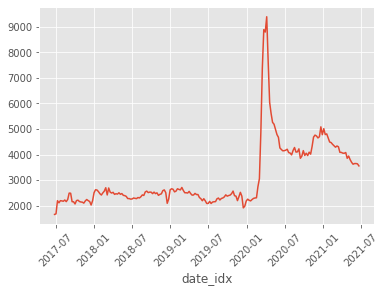

In [58]:
ax = df1.total_demand_new.plot()
ax.xaxis.set_tick_params(rotation=45)

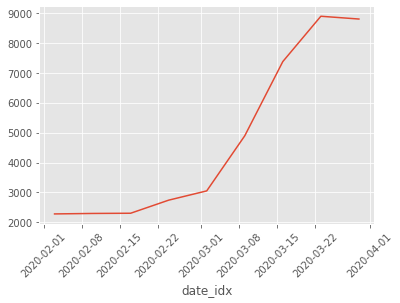

In [62]:
ax = df1.loc[(df1.date >= date(2020, 2, 1))
             & (df1.date <= date(2020, 4, 1))].total_demand_new.plot()
ax.xaxis.set_tick_params(rotation=45)

In [63]:
df1.loc[(df1.date >= date(2020, 2, 1))
             & (df1.date <= date(2020, 4, 1))].head()

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag-1,total_demand_new_lag-2,smoothed_total_demand,year
date_idx,,,,,,,,,
2020-02-03,1,2020-02-03,2284.282741,2240.671141,2185.916887,2300.108328,2307.138746,2258.458776,2020
2020-02-10,1,2020-02-10,2300.108328,2284.282741,2240.671141,2307.138746,2744.013630,2394.026565,2020
2020-02-17,1,2020-02-17,2307.138746,2300.108328,2284.282741,2744.013630,3053.383464,2595.447041,2020
2020-02-24,1,2020-02-24,2744.013630,2307.138746,2300.108328,3053.383464,4894.511205,3138.785436,2020
2020-03-02,1,2020-03-02,3053.383464,2744.013630,2307.138746,4894.511205,7372.533523,4329.549276,2020


In [ ]:
# [] need a way to detect the last pre-covid time (or can hardcode the cutoff)
# [] need a way to detect starting point (ie 3rd week, or once % change isn't > some amount)
    # [] or can see if its necessary to do this (ie maybe can leave data as is? unlikely it seems)


In [64]:
covid_start_idx = date(2020,2,17)

In [65]:
# d4_new = d4.loc[(d4.t < covid_start_idx)
#                 | (d4.t >= covid_start_idx + szn_len)]

d4_new = df1.loc[(df1.date < covid_start_idx)
                | (df1.date >= covid_start_idx + timedelta(weeks=52))]

d4_new.shape

(157, 9)

<AxesSubplot:xlabel='date_idx'>

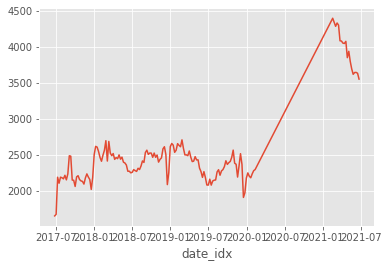

In [66]:
d4_new.total_demand_new.plot()

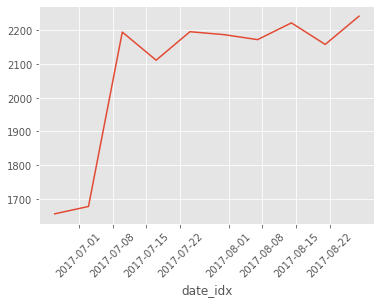

In [67]:
ax = df1.head(10).total_demand_new.plot()
ax.xaxis.set_tick_params(rotation=45)

In [61]:
df1.head()

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag-1,total_demand_new_lag-2,smoothed_total_demand,year
date_idx,,,,,,,,,
2017-06-26,1,2017-06-26,1656.912757,NaN,NaN,1678.654277,2193.532475,NaN,2017
2017-07-03,1,2017-07-03,1678.654277,1656.912757,NaN,2193.532475,2110.494687,NaN,2017
2017-07-10,1,2017-07-10,2193.532475,1678.654277,1656.912757,2110.494687,2194.632691,1910.173603,2017
2017-07-17,1,2017-07-17,2110.494687,2193.532475,1678.654277,2194.632691,2186.039578,2063.214755,2017
2017-07-24,1,2017-07-24,2194.632691,2110.494687,2193.532475,2186.039578,2171.274071,2165.335203,2017


In [68]:
d4_new = d4_new.loc[d4_new.date >= date(2017,7,10)]

<AxesSubplot:xlabel='date_idx'>

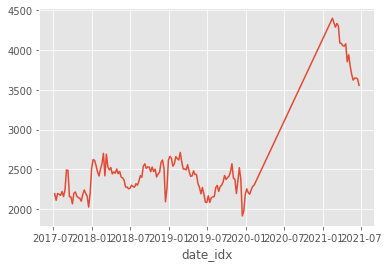

In [69]:
d4_new.total_demand_new.plot()

In [70]:
d4_new['y_obs'] = d4_new.total_demand_new
d4_new['y_obs_lag-1'] = d4_new.y_obs.shift(-1)

In [71]:
d4_new['covid_start_m1'] = d4_new.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=1) else 0)

# d4_new['covid_start_m1'] = d4.t.apply(lambda x: 1.0 if x == covid_start_idx - 1 else 0)

In [72]:
d4_new.loc[d4_new.date >= covid_start_idx - timedelta(weeks=3)].head(6)[['date', 'total_demand_new', 'covid_start_m1']]

,date,total_demand_new,covid_start_m1
date_idx,,,
2020-01-27,2020-01-27,2240.671141,0.0
2020-02-03,2020-02-03,2284.282741,0.0
2020-02-10,2020-02-10,2300.108328,1.0
2021-02-15,2021-02-15,4399.044636,0.0
2021-02-22,2021-02-22,4341.802063,0.0
2021-03-01,2021-03-01,4287.034614,0.0


In [153]:
szn_len = 52

with pm.Model() as hw_model:
#     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
    initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#     smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)
    
#     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
    initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
    smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
#     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)
    
    initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
#     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
#     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
#     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
#     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
    smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
#     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)
    
    ys = tt.as_tensor_variable(d4_new['y_obs'])
    is_covid_start = tt.as_tensor_variable(d4_new['covid_start_m1'])
#     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
#     covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=30000)
    covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
#     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
    covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
#     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
#     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)

    def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
        updated_szn = smoothing_season * y / (prior_level + prior_trend) + (1 - smoothing_season) * szn_m52


        next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + prior_trend) + covid_start*covid_level_change
        next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend - covid_start*smoothing_trend*covid_level_change2


        return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise,
           sequences = [
               ys[szn_len:],
               is_covid_start[szn_len:]
    #            post_covid[szn_len:]
           ],
           outputs_info = [
               dict(initial = initial_level, taps=None),
               dict(initial = initial_trend, taps=None),
               dict(initial = initial_szns, taps=[-szn_len])
           ], 
    #            non_sequences = 
           )


    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]
    

    levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
    trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
    seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])
    
    levels_and_trends = pm.math.stack([levels_f, trends_f])
    level_plus_trend = levels_and_trends.sum(axis=0)
    
    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    sig = pm.HalfCauchy('sigma', beta=10)
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=d4_new.iloc[szn_len-1:-1, :]['y_obs_lag-1'])

WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


In [154]:
map_estimate = pm.find_MAP(model=hw_model)

In [155]:
map_estimate

{'initial_level_interval__': array(0.01101077),
 'smoothing_level_interval__': array(1.32113847),
 'initial_trend_interval__': array(-0.00951848),
 'smoothing_trend_interval__': array(-8.07220974),
 'initial_szns': array([0.91859392, 0.90106594, 0.91147268, 0.9244865 , 0.92240303,
        0.95615813, 0.97837911, 0.95933692, 1.00189629, 1.01351687,
        1.00983802, 1.03131111, 1.02197205, 1.0155184 , 1.03297665,
        1.03328025, 1.06233719, 1.00523716, 1.01148345, 0.98078457,
        1.04103683, 1.08351142, 1.03152803, 0.84877207, 0.89999445,
        1.02272391, 1.04828178, 1.0360649 , 1.01036504, 1.02957536,
        1.06096346, 1.06063523, 1.05724847, 1.05942052, 1.03923272,
        1.04002184, 1.0371714 , 0.99916757, 1.00797   , 0.99595411,
        0.99075847, 0.99905726, 0.96726944, 0.98041292, 0.95759104,
        0.92808541, 0.91160507, 0.90909115, 0.92011459, 0.91068529,
        0.88601217, 0.88421397]),
 'smoothing_season_interval__': array(-11.44902071),
 'covid_level_chang

In [ ]:
# need to go back and pad the data correctly?

In [ ]:
# smoothing_level is actually pretty consistent with what it was when fitting statsmodels just on pre-covid data, but covid_level_change2 is looking wild and smoothing_trend_and_slope are wonky

# trying to center the covid_level_change2 around covid_level_change
# but then smoothing_trend and smoothin_season end up being ~0
# if let it stray too much, then they end up near 1. hmm

In [ ]:
# produce in-sample fit
# can do with theano.scan and passing the learned params?

In [147]:
def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
        updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


        next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + prior_trend) + covid_start*map_estimate['covid_level_change']
        next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


        return next_level, next_trend, updated_szn

outputs, updates = theano.scan(hw_component_wise_final,
           sequences = [
               ys[szn_len:],
               is_covid_start[szn_len:]
    #            post_covid[szn_len:]
           ],
           outputs_info = [
               dict(initial = map_estimate['initial_level'], taps=None),
               dict(initial = map_estimate['initial_trend'], taps=None),
               dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
           ], 
    #            non_sequences = 
           )

WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


In [148]:
levels = outputs[0]
trends = outputs[1]
seasons = outputs[2]


levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])

levels_and_trends = pm.math.stack([levels_f, trends_f])
level_plus_trend = levels_and_trends.sum(axis=0)

level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
y_hats = level_plus_trend_and_seasons.prod(axis=0)

In [149]:
len(y_hats.get_test_value())

103

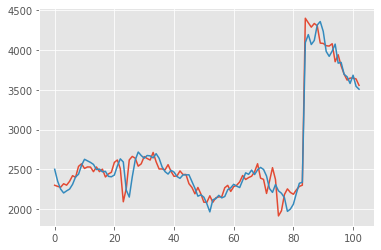

In [158]:
# d4_new.loc[~d4_new.y_obs.isna()].reset_index().y_obs.plot()
d4_new.iloc[szn_len:].reset_index().y_obs.plot()
plt.plot(y_hats.get_test_value())

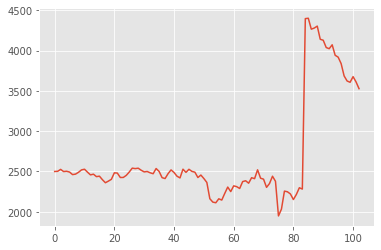

In [150]:
plt.plot(y_hats.get_test_value())

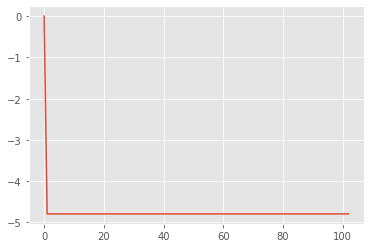

In [151]:
plt.plot(trends_f.get_test_value())

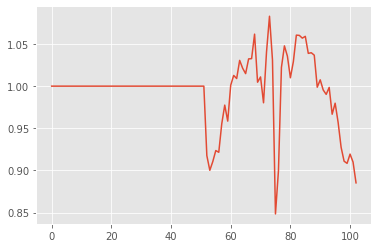

In [152]:
plt.plot(seasons_f.get_test_value())

In [90]:
d4_new.shape

(155, 12)

<AxesSubplot:xlabel='date_idx'>

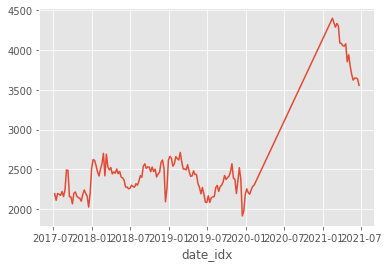

In [91]:
d4_new.y_obs.plot()

In [159]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

<ipython-input-163-1b0443fd2b2f>:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinte

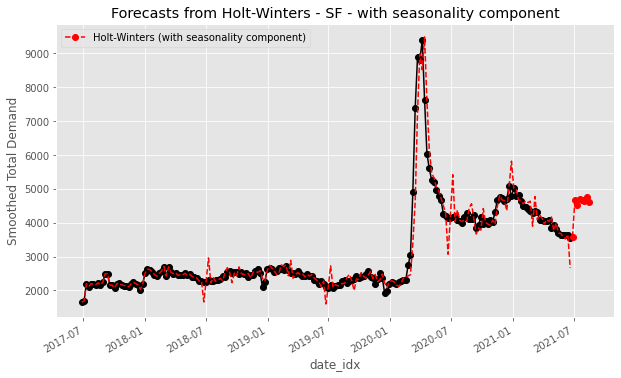

In [163]:
zdf = df1.sort_values('date').total_demand_new.astype(float)

fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
                            seasonal_periods=52,
#                             damped=True
                            damped=False
                           ).fit(optimized=True, use_boxcox=False)

ax = zdf.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters - SF - with seasonality component" )
ax.set_ylabel("Smoothed Total Demand")
ax.set_xlabel("Week")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')

fit1.forecast(8).rename('Holt-Winters (with seasonality component)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()

In [164]:
fit1.params

{'smoothing_level': 0.995,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.0050000000000000044,
 'damping_trend': nan,
 'initial_level': 2739.466870198668,
 'initial_trend': 2.6527671741768097,
 'initial_seasons': array([0.60483037, 0.61276677, 0.80071509, 0.77040344, 0.80111671,
        0.79797993, 0.79259001, 0.81062128, 0.78742048, 0.8178707 ,
        0.90940049, 0.90740225, 0.78642273, 0.78541204, 0.75400178,
        0.80260948, 0.80845264, 0.78911365, 0.78215889, 0.77968768,
        0.7660459 , 0.7970753 , 0.81763602, 0.80181342, 0.78916057,
        0.73914876, 0.80035325, 0.91522273, 0.95694916, 0.95343261,
        0.93069365, 0.90076863, 0.88161366, 0.91235579, 0.93734726,
        0.98576933, 0.88266913, 0.98203527, 0.92330179, 0.90977146,
        0.92057887, 0.89122446, 0.90050869, 0.89472575, 0.913821  ,
        0.89212857, 0.90248817, 0.87712068, 0.87292881, 0.86248664,
        0.83107948, 0.83122154]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<AxesSubplot:>

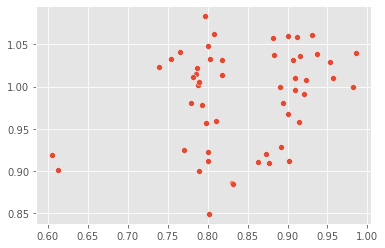

In [165]:
sns.scatterplot(x=fit1.params['initial_seasons'], y=map_estimate['initial_szns'])

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/results.py:169: FutureWarning: slope is deprecated and will be removed after 0.13
  warnings.warn(


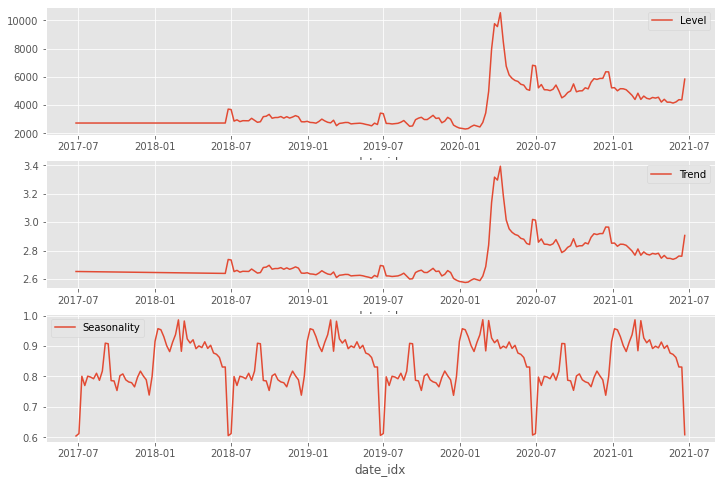

In [166]:
states1 = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season, fit1.fittedvalues], columns=['level','slope','seasonal', 'fitted_val'], index=zdf.index)

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,8))
states1.level.plot(ax=ax1, label='Level')
states1.slope.plot(ax=ax2, label='Trend')
states1.seasonal.plot(ax=ax3, label='Seasonality')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

In [ ]:
# walk-forward validation

In [ ]:
# our seasonality has a nice smooth shape compared to ^
# should do statsmodels with covid removed for better comparison

# can enforce sznality b/w 0 and 0.2 if we want to allow it to change a bit over time
# do wfv